In [1]:
import networkx as nx
import scipy.linalg as slg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.linalg as lg
from sklearn import preprocessing
from sklearn.manifold import MDS
import seaborn as sns
import scipy as sp
from pydiffmap import diffusion_map 
import random
sns.set_style('white')
from sklearn.preprocessing import Normalizer
random.seed(8579)
import ot
import copy
from scaccordion import tl as actl
from scipy.spatial.distance import is_valid_dm
import warnings
warnings.filterwarnings("ignore")

### Creating the synthetic network

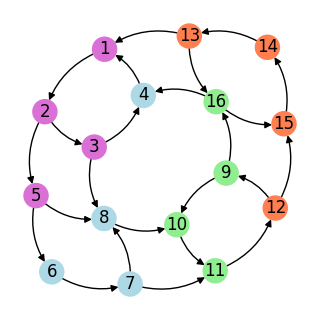

In [2]:
g1 = actl.datasets.make_gl_ciclic_graph()
nodecolors=['orchid']*4+['lightblue']*4+['lightgreen']*4 + ['coral']*4
plt.figure(figsize=(3,3))
lay=nx.nx_agraph.pygraphviz_layout(g1)
nx.draw(g1, 
        pos=lay,
        with_labels=True,
        edge_color=list(nx.get_edge_attributes(g1,'color').values()),
    connectionstyle="arc3,rad=0.25",node_color=nodecolors)

### Adding the Local and Global perturbations

In [3]:
g2 = g1.copy()
g3 = g1.copy()
g2.remove_edge(12,15)
g2.add_edge(15,12,color='red',width=3)
g3.remove_edge(16,15)
g3.add_edge(15,16,color='red',width=3)

In [4]:
aux1 = g2
g2 = g3
g3 = aux1

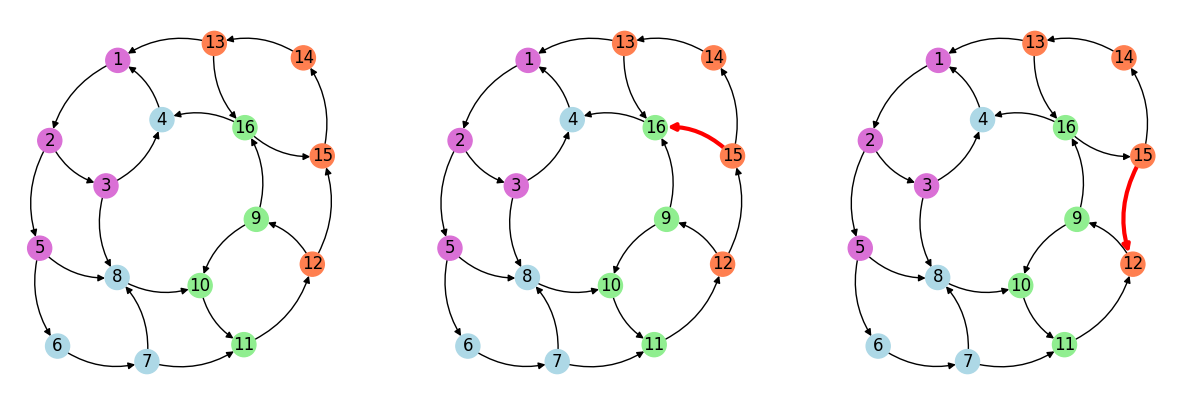

In [5]:
_,ax2 = plt.subplots(1,3,figsize=(15,5),dpi=100)
lay=nx.nx_agraph.pygraphviz_layout(g1)
ax2 = ax2.ravel()
nx.draw(g1, 
        pos=lay,
        with_labels=True,ax=ax2[0],
        edge_color=list(nx.get_edge_attributes(g1,'color').values()),
    connectionstyle="arc3,rad=0.25",node_color=nodecolors)
nx.draw(g2, pos=lay,with_labels=True,ax=ax2[1],
        edge_color=list(nx.get_edge_attributes(g2,'color').values()),node_color=nodecolors,
        connectionstyle="arc3,rad=0.25",width=list(nx.get_edge_attributes(g2,'width').values()))
nx.draw(g3, pos=lay,with_labels=True,ax=ax2[2],
        edge_color=list(nx.get_edge_attributes(g3,'color').values()),node_color=nodecolors,
        connectionstyle="arc3,rad=0.25",width=list(nx.get_edge_attributes(g3,'width').values()))
plt.savefig("ICASSP_example_fig1.pdf")

#### Computing the first baseline: The Frobenius norm between the adjacency matrices

In [6]:
l2c0 = np.linalg.norm(nx.to_numpy_matrix(g1) - nx.to_numpy_matrix(g1))
l2c1 = np.linalg.norm(nx.to_numpy_matrix(g1) - nx.to_numpy_matrix(g2))
l2c2 = np.linalg.norm(nx.to_numpy_matrix(g1) - nx.to_numpy_matrix(g3))
print('$Frobenius_norm(A_{1}-A_{2})$:'+f'{round(l2c1,3)}')
print('$Frobenius_norm(A_{1}-A_{2})$:'+f'{round(l2c2,3)}')


$Frobenius_norm(A_{1}-A_{2})$:1.414
$Frobenius_norm(A_{1}-A_{2})$:1.414


#### Creating the ACCorDiON object with graphs

In [7]:
synthetic = {}
synthetic["G"] = nx.to_pandas_edgelist(g1).iloc[:,0:2]
synthetic["G"].columns = ['source','target']
synthetic["G"]['lr_means']=np.ones(len(synthetic['G'].index))
synthetic["G"]['source']=synthetic["G"]['source'].astype('str')
synthetic["G"]['target'] = synthetic["G"]['target'].astype('str')

synthetic["G1"] = nx.to_pandas_edgelist(g2).iloc[:,0:2]
synthetic["G1"].columns = ['source','target']
synthetic["G1"]['lr_means']=np.ones(len(synthetic['G1'].index))
synthetic["G1"]['source']=synthetic["G1"]['source'].astype('str')
synthetic["G1"]['target'] = synthetic["G1"]['target'].astype('str')

synthetic["G2"] = nx.to_pandas_edgelist(g3).iloc[:,0:2]
synthetic["G2"].columns = ['source','target']
synthetic["G2"]['lr_means']=np.ones(len(synthetic['G2'].index))
synthetic["G2"]['source']=synthetic["G2"]['source'].astype('str')
synthetic["G2"]['target'] = synthetic["G2"]['target'].astype('str')

### Making a PCA using the edgelist of the graphs

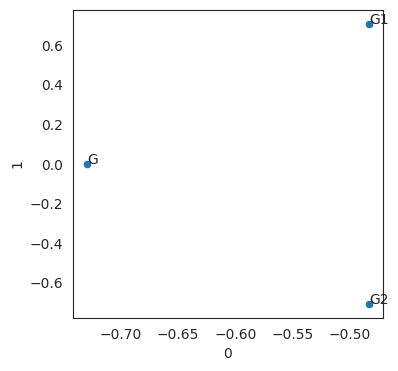

In [21]:
Syn = actl.Accordion(tbls=synthetic,filter=0.0,weight='lr_means')
plt.figure(figsize=(4,4))
Syn.make_pca()
sns.scatterplot(x=0,y=1,data=Syn.Cs['PCA'])
for i in range(Syn.Cs['PCA'].shape[0]):
    plt.text(x=Syn.Cs['PCA'].iloc[i,0],
             y=Syn.Cs['PCA'].iloc[i,1],
             s=Syn.Cs['PCA'].index.tolist()[i])

### Computing the EMD using the directed weighted graph based distances

In [9]:
Syn.compute_cost(mode='GRD')
Syn.compute_cost(mode='HTD')
Syn.compute_cost(mode='HTD',beta=1)
fro1=[l2c0,l2c1,l2c2]
mg1 = nx.to_numpy_array(g1)
mg2 = nx.to_numpy_array(g2)
mg3 = nx.to_numpy_array(g3)

n=len(g1.nodes())
mA =(1/n) *np.ones(n)
gwot0 = actl.GWOT.emd2RTLB(mg1,mg1,mA,mA)
gwot = actl.GWOT.emd2RTLB(mg1,mg2,mA,mA)
gwot1 = actl.GWOT.emd2RTLB(mg1,mg3,mA,mA)

lgwot=[gwot0[0],gwot[0],gwot1[0]]
ug1 = nx.to_undirected(g1)
ug2 = nx.to_undirected(g2)
ug3 = nx.to_undirected(g3)
lug1 = nx.laplacian_matrix(ug1)
lug2 = nx.laplacian_matrix(ug2)
lug3 = nx.laplacian_matrix(ug3)

ugot =[actl.GOT.wass_dist_(lug1.todense(),lug1.todense()),
       actl.GOT.wass_dist_(lug1.todense(),lug2.todense()), 
       actl.GOT.wass_dist_(lug1.todense(),lug3.todense())]


pre-EMD-time:0.0019864042599995932 minutes
post-EMD-time:7.700920104980468e-06 minutes
pre-EMD-time:0.0010601282119750977 minutes
post-EMD-time:3.540515899658203e-06 minutes
pre-EMD-time:0.000931258996327718 minutes
post-EMD-time:3.2862027486165364e-06 minutes


In [10]:
tmp = pd.DataFrame(Syn.Cs['GRD'],index=Syn.expgraph.nodes)

In [11]:
tmp.columns = Syn.expgraph.nodes

In [12]:
#Syn.Cs['GRD'][np.isnan(Syn.Cs['GRD'])]=np.nanmax(Syn.Cs['GRD'])
Syn.compute_wassestein()
Syn.compute_wassestein(cost='HTD_0.5')
Syn.compute_wassestein(cost='HTD_1')


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1804.78it/s]


In [13]:
g1m = nx.to_pandas_adjacency(g1).apply(lambda x:x/(sum(x)+1e-10),axis=1).to_numpy()
g2m = nx.to_pandas_adjacency(g2).apply(lambda x:x/(sum(x)+1e-10),axis=1).to_numpy()
g3m = nx.to_pandas_adjacency(g3).apply(lambda x:x/(sum(x)+1e-10),axis=1).to_numpy()

In [14]:
ng1m = nx.from_numpy_matrix(g1m,create_using=nx.DiGraph)
ng2m = nx.from_numpy_matrix(g2m,create_using=nx.DiGraph)
ng3m = nx.from_numpy_matrix(g3m,create_using=nx.DiGraph)

In [15]:
ctdg = actl.distances.ctd_dist(g1)
ctdg1 = actl.distances.ctd_dist(g2)
ctdg2 = actl.distances.ctd_dist(g3)


In [16]:
gwgrd=[ot.gromov_wasserstein2(C1=ctdg,
                       C2=ctdg,
                       p=ot.unif(n=ctdg.shape[0]),
                       q=ot.unif(n=ctdg.shape[0]),
                       loss_fun='square_loss'),
ot.gromov_wasserstein2(C1=ctdg,
                       C2=ctdg1,
                       p=ot.unif(n=ctdg.shape[0]),
                       q=ot.unif(n=ctdg.shape[0]),
                       loss_fun='square_loss'),
ot.gromov_wasserstein2(C1=ctdg,
                       C2=ctdg2,
                       p=ot.unif(n=ctdg.shape[0]),
                       q=ot.unif(n=ctdg.shape[0]),
                       loss_fun='square_loss')]

In [17]:
ctdg = actl.distances.get_dhp(g1m)
ctdg1 = actl.distances.get_dhp(g2m)
ctdg2 = actl.distances.get_dhp(g3m)
gwhtd05=[ot.gromov_wasserstein2(C1=ctdg,
                       C2=ctdg,
                       p=ot.unif(n=ctdg.shape[0]),
                       q=ot.unif(n=ctdg.shape[0]),
                       loss_fun='square_loss'),
ot.gromov_wasserstein2(C1=ctdg,
                       C2=ctdg1,
                       p=ot.unif(n=ctdg.shape[0]),
                       q=ot.unif(n=ctdg.shape[0]),
                       loss_fun='square_loss'),
ot.gromov_wasserstein2(C1=ctdg,
                       C2=ctdg2,
                       p=ot.unif(n=ctdg.shape[0]),
                       q=ot.unif(n=ctdg.shape[0]),
                       loss_fun='square_loss')]
ctdg = actl.distances.get_dhp(g1m,beta=1)
ctdg1 = actl.distances.get_dhp(g2m,beta=1)
ctdg2 = actl.distances.get_dhp(g3m,beta=1)

gwhtd1=[ot.gromov_wasserstein2(C1=ctdg,
                       C2=ctdg,
                       p=ot.unif(n=ctdg.shape[0]),
                       q=ot.unif(n=ctdg.shape[0]),
                       loss_fun='square_loss'),
ot.gromov_wasserstein2(C1=ctdg,
                       C2=ctdg1,
                       p=ot.unif(n=ctdg.shape[0]),
                       q=ot.unif(n=ctdg.shape[0]),
                       loss_fun='square_loss'),
ot.gromov_wasserstein2(C1=ctdg,
                       C2=ctdg2,
                       p=ot.unif(n=ctdg.shape[0]),
                       q=ot.unif(n=ctdg.shape[0]),
                       loss_fun='square_loss')]

In [18]:
ctdg = actl.distances.get_dhp(g1m,beta=1)
ctdg1 = actl.distances.get_dhp(g2m,beta=1)
ctdg2 = actl.distances.get_dhp(g3m,beta=1)


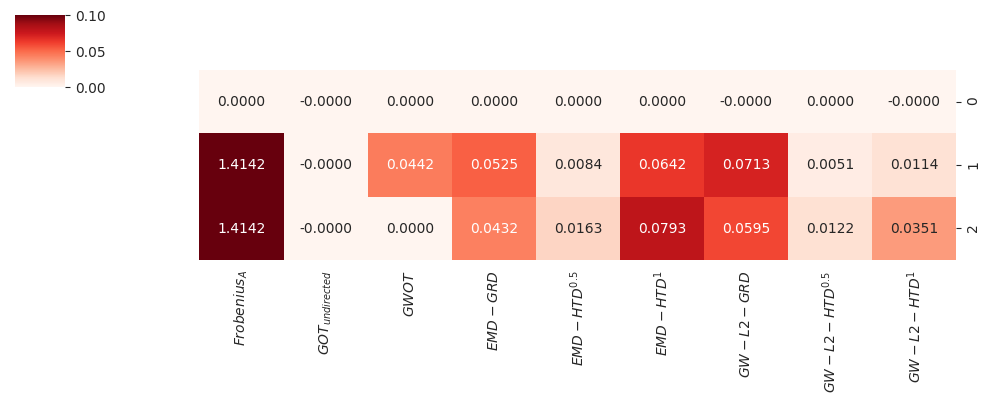

In [19]:
 distfrG = pd.DataFrame.from_dict({
                        '$Frobenius_{A}$':fro1,
                        "$GOT_{undirected}$":ugot,
                        "$GWOT$":lgwot,
                        '$EMD-GRD$':Syn.wdist['GRD']['G'].tolist(),
                        '$EMD-HTD^{0.5}$':Syn.wdist['HTD_0.5']['G'].tolist(),
                        '$EMD-HTD^{1}$':Syn.wdist['HTD_1']['G'].tolist(),
                        '$GW-L2-GRD$':gwgrd,
                        '$GW-L2-HTD^{0.5}$':gwhtd05,
                        '$GW-L2-HTD^{1}$':gwhtd1,})
sns.clustermap(distfrG,
               cmap='Reds',
               annot=True, 
               fmt=".4f",
               row_cluster=False,figsize=(10,4),col_cluster=False,vmin=0,vmax=0.1)